# Imports and settings

In [1]:
import adaptive_latents as al
from adaptive_latents import mmICA, sjPCA, proSVD, CenteringTransformer, Pipeline, NumpyTimedDataSource
import matplotlib.pyplot as plt
import numpy as np
from datasets import Leventhal24uDataset
from picard import permute
import sklearn
import matlab.engine
import scipy.stats as stats

rng = np.random.default_rng(1)
eng = matlab.engine.start_matlab()


/home/jgould/miniconda3/envs/adaptive_latents_38/lib/python3.8/site-packages/mmica/_densities.py:43: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, fastmath=True)
/home/jgould/miniconda3/envs/adaptive_latents_38/lib/python3.8/site-packages/mmica/_densities.py:57: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, fastmath=True)


# Simulated data

In [2]:
plt.rc('lines', linewidth=2)
plt.rc('font', family='sans')

dt = 0.03 # seconds
T = 60 # seconds
iterations_to_run = 10

colors = ["#F94B00", "#2FA194", "#EC3C8E"]
common_ylim = [.005, 4]
common_xticks = [0, 30, 60] 


In [3]:
def plot(offline_errors, trajectories, t, i, name):
    fig, ax = plt.subplots()
    fig: plt.Figure
    lower = np.quantile(offline_errors, stats.norm(0,1).cdf(-1))
    upper = np.quantile(offline_errors, stats.norm(0,1).cdf(1))
    ax.axhline(np.quantile(offline_errors, .5), color='k', alpha=.75)
    ax.fill_between([t[0], t[-1]], upper, lower, color='k', edgecolor=None,  alpha=.25)
    ax.autoscale(False)

    lower = np.quantile(trajectories, stats.norm(0,1).cdf(-1), axis=0)
    upper = np.quantile(trajectories, stats.norm(0,1).cdf(1), axis=0)
    trajectory = np.mean(trajectories, axis=0)
    ax.plot(t, trajectory, color=colors[i])
    ax.fill_between(t, upper, lower, color=colors[i], edgecolor=None,  alpha=.5)

    ax.set_xlabel('time (s)')
    ax.set_ylabel('error')
    ax.set_xticks(common_xticks)

    ax.semilogy()
    ax.set_yticks([1, .1, .01])
    ax.minorticks_off()
    ax.set_ylim(common_ylim)
    ax.set_xticks(common_xticks)

    ax.set_title(f"{name} error")
    fig.savefig(f"{al.CONFIG['plot_save_path']}/{name}.svg")

    return fig, ax

## sjPCA

analyzing all times
mild warning!!!!: you are using a short time base which might make the computation of the derivative a bit less reliable
analyzing all times
mild warning!!!!: you are using a short time base which might make the computation of the derivative a bit less reliable
analyzing all times
mild warning!!!!: you are using a short time base which might make the computation of the derivative a bit less reliable
analyzing all times
mild warning!!!!: you are using a short time base which might make the computation of the derivative a bit less reliable
analyzing all times
mild warning!!!!: you are using a short time base which might make the computation of the derivative a bit less reliable
analyzing all times
mild warning!!!!: you are using a short time base which might make the computation of the derivative a bit less reliable
analyzing all times
mild warning!!!!: you are using a short time base which might make the computation of the derivative a bit less reliable
analyzing all

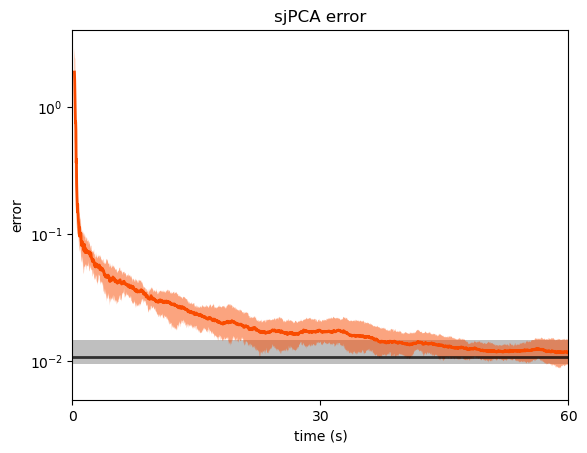

In [4]:
trajectories = []
offline_errors = []
for _ in range(iterations_to_run):
    X, _, true_variables = al.jpca.generate_circle_embedded_in_high_d(rng, m=int(T/dt), n=6, stddev=1)

    # matlab section
    params = dict(
        meanSubtract=False,
        normalize=False,
        suppressBWrosettes=True,
        suppressHistograms=True,
        suppressText=True,
    )
    proj, summary = eng.jPCA({'A':X}, [], params, nargout=2)
    offline_U = np.array(summary['jPCs_highD'])
    offline_error = np.abs(al.utils.principle_angles(offline_U[:,:2], true_variables['C'])).sum()
    offline_errors.append(offline_error)

    # my section
    jp = sjPCA(log_level=1)
    jp.offline_run_on(NumpyTimedDataSource(X, timepoints = np.arange(X.shape[0]) * dt))
    distances, t = jp.get_distance_from_subspace_over_time(true_variables['C'])
    trajectories.append(distances[:,0])

fig, ax = plot(offline_errors, trajectories, t, 0, 'sjPCA')

## mmICA

/home/jgould/miniconda3/envs/adaptive_latents_38/lib/python3.8/site-packages/numba/core/typed_passes.py:334: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/adaptive_latents_38/lib/python3.8/site-packages/mmica/_densities.py", line 44:
@jit(parallel=True, fastmath=True)
def logp_u(Y):
^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


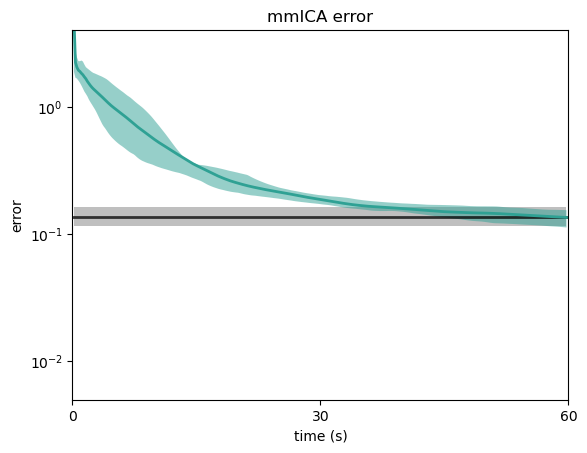

In [5]:
trajectories = []
offline_errors = []
for _ in range(iterations_to_run):
    n = 6
    m = int((T/dt)//n) # number of blocks
    X = rng.laplace(size=(m, n, n))

    ica = mmICA(alpha=.5, maxiter_cg=20, tol=1e-20, log_level=1)
    input_data = NumpyTimedDataSource(X, timepoints = np.arange(m) * n * dt )
    ica.offline_run_on(input_data)
    ts = []
    errors = []
    for W, t in zip(ica.log['W'], ica.log['t']):
        ts.append(t)
        error = permute(W) - np.eye(W.shape[0])
        errors.append(np.linalg.norm(error))
    t = np.squeeze(ts)
    trajectories.append(np.squeeze(errors))
    


    W = sklearn.decomposition.FastICA(max_iter=5000).fit(X.transpose([0,2,1]).reshape(-1,n)).components_
    offline_error = np.linalg.norm(permute(W) - np.eye(W.shape[0]))
    offline_errors.append(offline_error)

fig, ax = plot(offline_errors, trajectories, t, 1, 'mmICA')


## proSVD

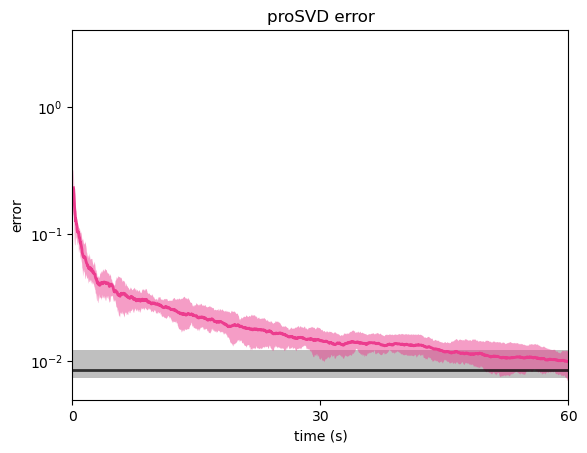

In [6]:
trajectories = []
offline_errors = []
for _ in range(iterations_to_run):
    X, _, true_variables = al.jpca.generate_circle_embedded_in_high_d(rng, m=int(T/dt), n=8, stddev=1)
    pro = proSVD(k=4, log_level=1)
    pro.offline_run_on(NumpyTimedDataSource(X, timepoints=np.arange(X.shape[0]) * dt))
    Q_error, t = pro.get_distance_from_subspace_over_time(true_variables['C'])
    trajectories.append(Q_error)

    _, s, Vt = np.linalg.svd(X)
    V = Vt[np.argsort(s)[::-1], :].T[:,:pro.k]
    offline_error = np.abs(al.utils.principle_angles(V,true_variables['C'])).sum()
    offline_errors.append(offline_error)

fig, ax = plot(offline_errors, trajectories, t, 2, 'proSVD')